# CIFAR-10 데이터를 이용해 Multi Layer Perceptron(MLP) 설계

## 모듈 import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

## 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0  Device: cpu


## CIFAR10 데이터 다운로드 (Train set, Test set 분리하기)

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


## 데이터 확인

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


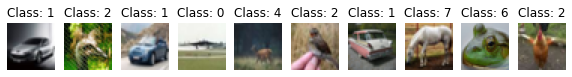

In [5]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

## Multi Layer Perceptron (MLP) 모델 설계

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x 

## Optimizer, Objective Function 설정

In [7]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [8]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

## 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.310308
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.147545
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.762378
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.955588
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.995027
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.743609
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.535293
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.804225

[EPOCH: 1], 	Test Loss: 0.0531, 	Test Accuracy: 39.61 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.631655
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.874974
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.720917
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.842685
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.765366
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.690671
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.467813
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.610595

[EPOCH: 2], 	Test Loss: 0.0499, 	Test Accuracy: 43.69 % 

# CIFAR-10 데이터를 이용해 ConvolutionalNeuralNetwork(CNN) 설계

## Convolutional Neural Network (CNN) 모델 설계

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [14]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/var/folders/42/fxl3_n31121f16yj69fbrb_m0000gn/T/ipykernel_99053/3698544584.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.307422
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.956001
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.798566
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.679811
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.628520
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.761042
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.413663
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.508286

[EPOCH: 1], 	Test Loss: 0.0444, 	Test Accuracy: 47.78 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.566940
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.534225
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.499643
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.320357
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.253275
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.200736
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.524310
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.127550

[EPOCH: 2], 	Test Loss: 0.0415, 	Test Accuracy: 52.75 % 

# Data Augmentation 적용

## 데이터 증강

In [16]:
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR_10/cifar-10-python.tar.gz to ./data/CIFAR_10


## 모델 훈련

In [19]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/var/folders/42/fxl3_n31121f16yj69fbrb_m0000gn/T/ipykernel_99053/3698544584.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.296340
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.670738
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.550171
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.645694
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.658849
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.656680
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.196678
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.411101

[EPOCH: 1], 	Test Loss: 0.0419, 	Test Accuracy: 51.71 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.223824
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.137339
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.496208
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.423000
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.344940
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.307205
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.198618
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.233058

[EPOCH: 2], 	Test Loss: 0.0377, 	Test Accuracy: 57.58 % 

## 증강 데이터 합치기

In [30]:
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())



aug_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_dataset.data = np.r_[train_dataset.data, aug_dataset.data]
train_dataset.targets = train_dataset.targets + aug_dataset.targets

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(100000, 32, 32, 3)


In [29]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/var/folders/42/fxl3_n31121f16yj69fbrb_m0000gn/T/ipykernel_99053/3698544584.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/100000 (0%)]	Train Loss: 2.293679
Train Epoch: 1 [6400/100000 (6%)]	Train Loss: 2.022727
Train Epoch: 1 [12800/100000 (13%)]	Train Loss: 1.941785
Train Epoch: 1 [19200/100000 (19%)]	Train Loss: 1.785678
Train Epoch: 1 [25600/100000 (26%)]	Train Loss: 1.875970
Train Epoch: 1 [32000/100000 (32%)]	Train Loss: 1.296713
Train Epoch: 1 [38400/100000 (38%)]	Train Loss: 1.511643
Train Epoch: 1 [44800/100000 (45%)]	Train Loss: 1.382116
Train Epoch: 1 [51200/100000 (51%)]	Train Loss: 1.642063
Train Epoch: 1 [57600/100000 (58%)]	Train Loss: 1.421285
Train Epoch: 1 [64000/100000 (64%)]	Train Loss: 1.190017
Train Epoch: 1 [70400/100000 (70%)]	Train Loss: 1.274152
Train Epoch: 1 [76800/100000 (77%)]	Train Loss: 1.571397
Train Epoch: 1 [83200/100000 (83%)]	Train Loss: 1.596756
Train Epoch: 1 [89600/100000 (90%)]	Train Loss: 1.421304
Train Epoch: 1 [96000/100000 (96%)]	Train Loss: 1.329274

[EPOCH: 1], 	Test Loss: 0.0436, 	Test Accuracy: 50.56 % 

Train Epoch: 2 [0/100000 (0%)]	Train

# ResNet 모델 설계

## 이전 처리 작업

Using PyTorch version: 1.9.0  Device: cpu
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


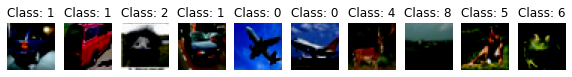

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
    
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))    

## 모델 설계

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [9]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
            
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy     

In [36]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.542609
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.272654
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.471444
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.233615
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.277305
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.141334
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.931802
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.092556

[EPOCH: 1], 	Test Loss: 0.0330, 	Test Accuracy: 61.90 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.097307
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.769045
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.078946
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.089809
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.737194
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.031132
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.049593
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.723856

[EPOCH: 2], 	Test Loss: 0.0264, 	Test Accuracy: 70.21 % 

# ResNet34 모델을 불러와 사용하기

## 모델 생성

In [11]:
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(DEVICE)

## 훈련

In [12]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.516512
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.682794
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.878962
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.552888
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.871261
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.615660
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.420608
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.777201

[EPOCH: 1], 	Test Loss: 0.0826, 	Test Accuracy: 9.12 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.689682
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.504428
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.883367
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.742044
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.694003
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.711046
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.758282
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.564830

[EPOCH: 2], 	Test Loss: 0.0825, 	Test Accuracy: 9.51 % 



## 미리 학습된 파라미터 이용

In [ ]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(DEVICE)

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

# 대용량의 데이터를 이용해 학습이 완료된 모델을 적은 수의 데이터에 맞게 Fine—tuning하는 Transfer Learning 실습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## 데이터 가져오기

In [2]:
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder("./data/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 8, num_workers = 0, shuffle = True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## 데이터 확인

In [3]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([8, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([8]) type: torch.LongTensor


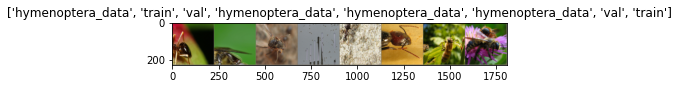

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 훈련을 위한 함수

In [5]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [6]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction = "sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 모델 생성 및 훈련

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

model = models.resnet18(pretrained = False).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, test_loss, test_accuracy))

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/794 (0%)]	Loss: 7.111545
Train Epoch: 1 [80/794 (10%)]	Loss: 6.591760
Train Epoch: 1 [160/794 (20%)]	Loss: 4.625225
Train Epoch: 1 [240/794 (30%)]	Loss: 4.155381
Train Epoch: 1 [320/794 (40%)]	Loss: 2.952668
Train Epoch: 1 [400/794 (50%)]	Loss: 2.897287
Train Epoch: 1 [480/794 (60%)]	Loss: 2.350625
Train Epoch: 1 [560/794 (70%)]	Loss: 1.235106
Train Epoch: 1 [640/794 (80%)]	Loss: 1.685644
Train Epoch: 1 [720/794 (90%)]	Loss: 1.533529
[1] Test Loss: 1.2390, accuracy: 45.47%

Train Epoch: 2 [0/794 (0%)]	Loss: 1.350346
Train Epoch: 2 [80/794 (10%)]	Loss: 1.040497
Train Epoch: 2 [160/794 (20%)]	Loss: 1.207715
Train Epoch: 2 [240/794 (30%)]	Loss: 1.005815
Train Epoch: 2 [320/794 (40%)]	Loss: 0.911432
Train Epoch: 2 [400/794 (50%)]	Loss: 0.783959
Train Epoch: 2 [480/794 (60%)]	Loss: 1.433756
Train Epoch: 2 [560/794 (70%)]	Loss: 0.957163
Train Epoch: 2 [640/794 (80%)]	Loss: 1.184910
Train Epoch: 2 [720/794 (90%)]	Loss: 1.474311
[2] Test Loss: 1.1838, accuracy: 37.41%

Train 

## Fine-Tuning

## 모델을 학습하기 위한 일반 함수

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## 일부 이미지에 대한 예측값을 보여주는 일반화된 함수

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2040 Acc: 0.3854
val Loss: 1.0628 Acc: 0.4068

Epoch 1/9
----------
train Loss: 1.1793 Acc: 0.4030
val Loss: 1.0675 Acc: 0.4131

Epoch 2/9
----------
train Loss: 1.1356 Acc: 0.4320
val Loss: 1.0130 Acc: 0.4710

Epoch 3/9
----------
train Loss: 1.0935 Acc: 0.4307
val Loss: 1.0136 Acc: 0.4950

Epoch 4/9
----------
train Loss: 1.1448 Acc: 0.4144
val Loss: 1.0155 Acc: 0.4987

Epoch 5/9
----------
train Loss: 1.0787 Acc: 0.4484
val Loss: 1.0424 Acc: 0.4975

Epoch 6/9
----------
train Loss: 1.1393 Acc: 0.4144
val Loss: 0.9715 Acc: 0.4937

Epoch 7/9
----------
train Loss: 0.9892 Acc: 0.4849
val Loss: 0.9480 Acc: 0.4887

Epoch 8/9
----------
train Loss: 0.9880 Acc: 0.4811
val Loss: 0.9495 Acc: 0.4937

Epoch 9/9
----------
train Loss: 0.9629 Acc: 0.4773
val Loss: 0.9450 Acc: 0.4773

Training complete in 30m 48s
Best val Acc: 0.498741


NameError: name 'device' is not defined

<Figure size 432x288 with 0 Axes>

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.2006 Acc: 0.2594
val Loss: 1.1675 Acc: 0.2897

Epoch 1/9
----------


FileNotFoundError: [Errno 2] No such file or directory: './data/hymenoptera_data/hymenoptera_data/train/bees/2908916142_a7ac8b57a8.jpg'